In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv("df.csv")

In [6]:
df.drop('Unnamed: 0', axis = 1, inplace = True)

In [7]:
df['rating_point'] = df['rating'] * df['rating_count']
df['merchant_rating_point'] = df['merchant_rating'] * df['merchant_rating_count']

In [10]:
drop_list = ['rating', 'rating_count', 'merchant_rating', 'merchant_rating_count', 'nb_cart_orders_approx']
df2 = df.drop(drop_list, axis = 1)

In [11]:
df2.head()

,category,currency,discount_price,discount_rate,shipping_option_price,shipping_is_express,has_urgency_banner,origin_country,size_var,rating_point,merchant_rating_point
0,bodysuit,EUR,13.00,0.826667,4.0,0,0,CN,5.0,139.0,22250.0
1,bodysuit,EUR,4.74,0.952600,2.0,0,1,CN,12.0,56.0,38.0
2,bodysuit,EUR,4.00,0.000000,1.0,0,0,CN,5.0,3355.0,151563.0
3,bodysuit,EUR,8.00,0.000000,3.0,0,0,CN,7.0,4.0,91244.0
4,bodysuit,EUR,14.00,0.831325,4.0,0,0,CN,4.0,56.0,97476.0


In [15]:
target = 'rating_point'
features = df2.columns.difference([target], sort=False)

from sklearn.model_selection import train_test_split

train_val, test = train_test_split(df2, train_size = 0.8, test_size = 0.2, random_state = 2)
train, val = train_test_split(train_val, train_size = 0.8, test_size = 0.2, random_state = 2)

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

<AxesSubplot:xlabel='rating_point', ylabel='Density'>

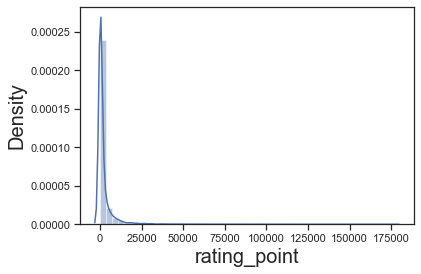

In [18]:
sns.distplot(df2[target])

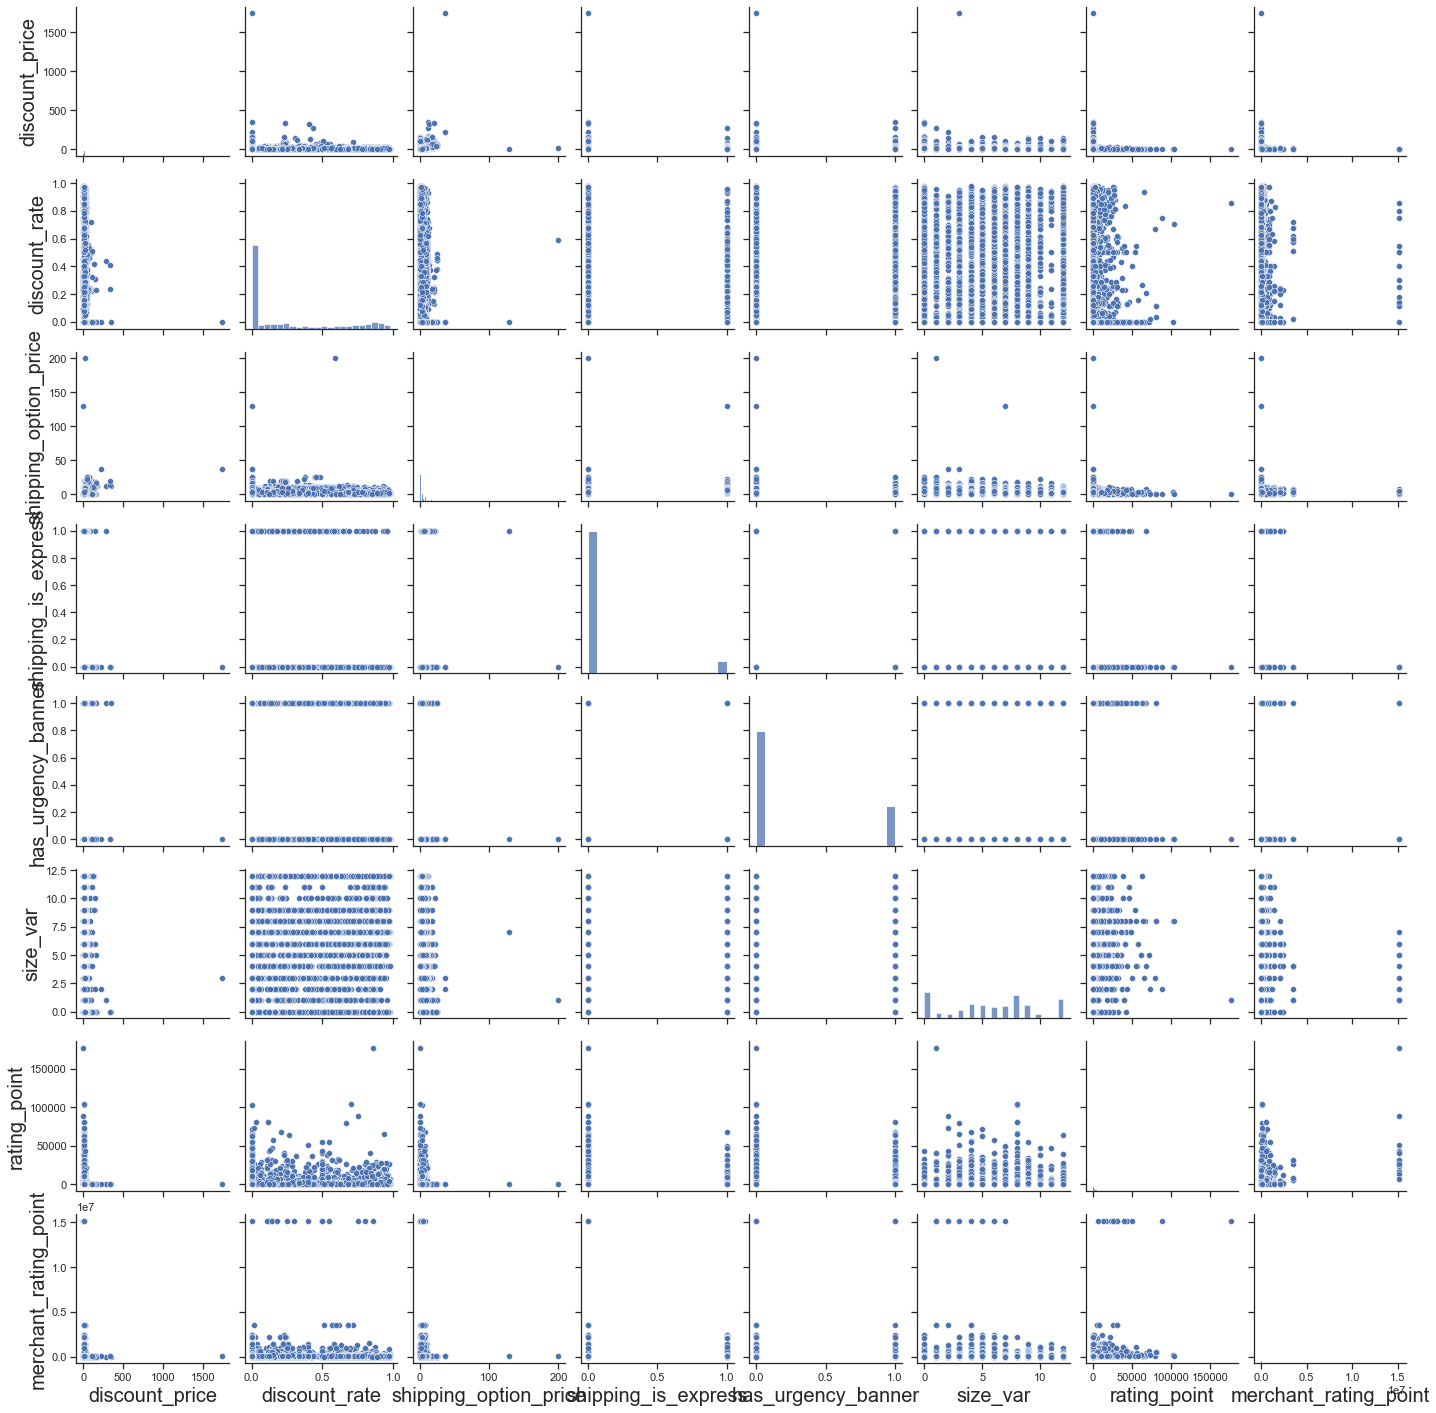

In [19]:
sns.set(style="ticks", color_codes=True)
plt.rcParams["axes.labelsize"] = 20
sns.pairplot(df2)

<AxesSubplot:>

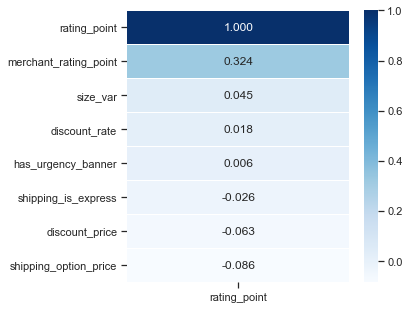

In [20]:
# correlation

corr = df2.corr()[[target]].sort_values(by = target, ascending=False)

f, ax = plt.subplots(figsize = (5,5))
sns.heatmap(corr, annot=True, fmt="0.3f", linewidths=0.1, ax=ax, cmap='Blues')

In [22]:
df3 = df2.drop('merchant_rating_point', axis = 1)

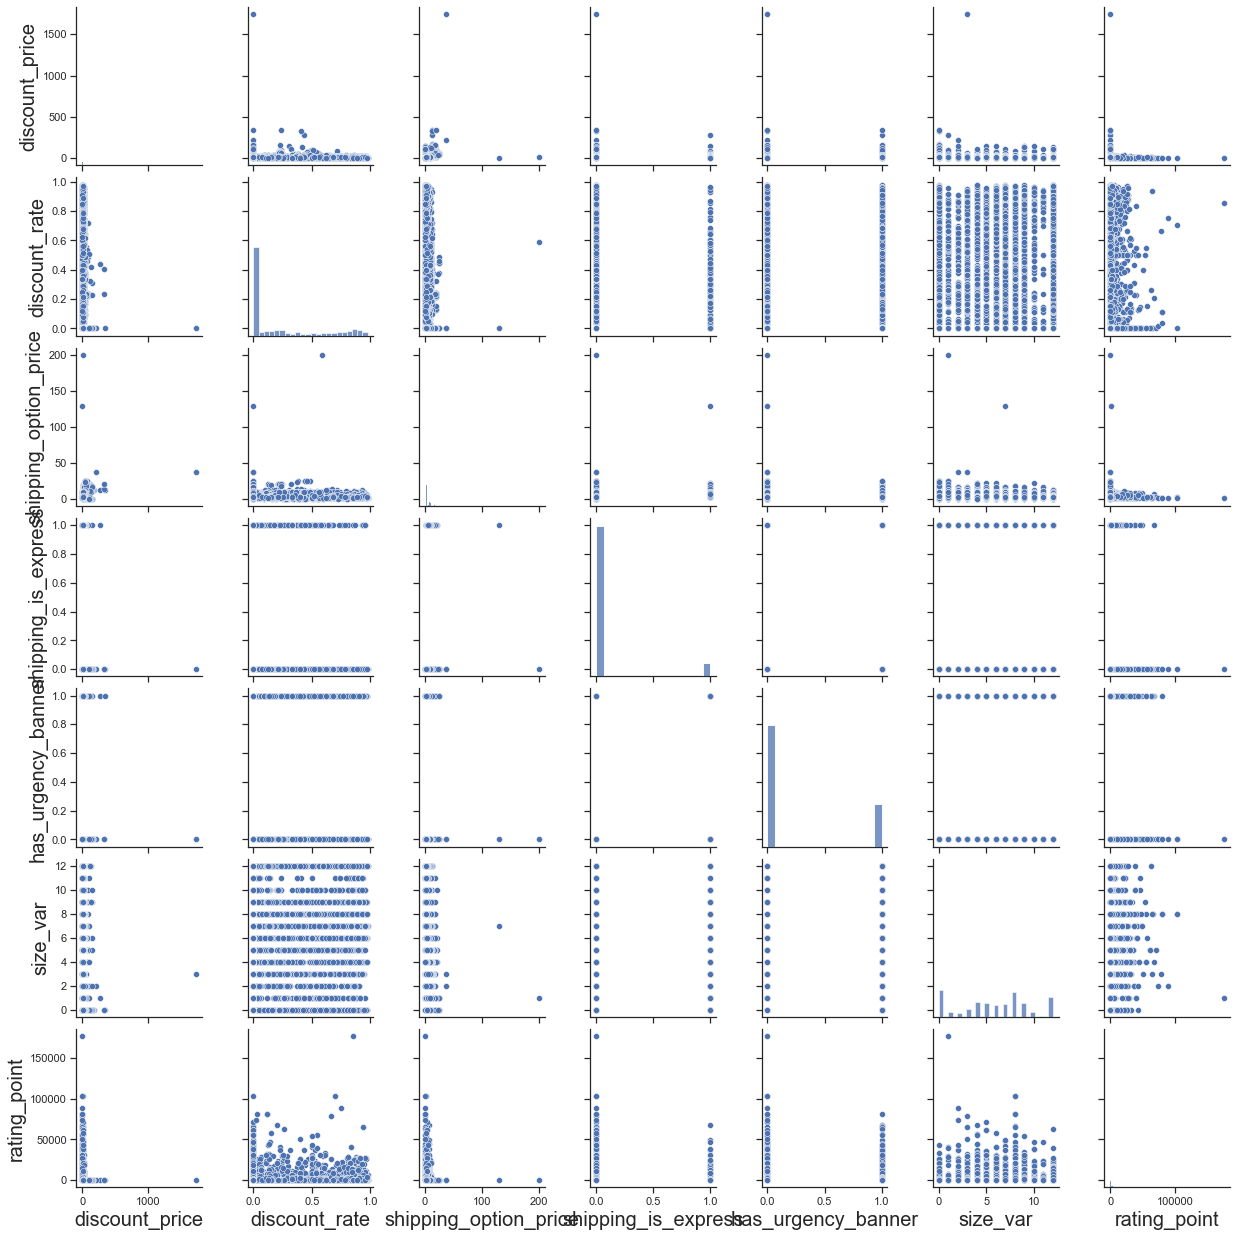

In [27]:
sns.set(style="ticks", color_codes=True)
plt.rcParams["axes.labelsize"] = 20
sns.pairplot(df3)

<AxesSubplot:>

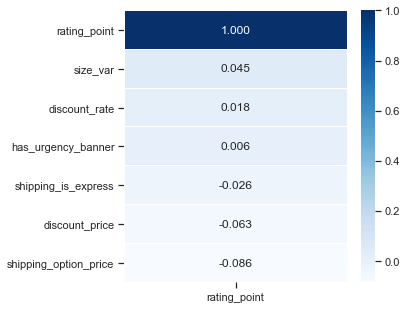

In [26]:
f, ax = plt.subplots(figsize = (5,5))
sns.heatmap(df3.corr()[[target]].sort_values(by = target, ascending=False)
                                   , annot=True, fmt="0.3f", linewidths=0.1, ax=ax, cmap='Blues')

<AxesSubplot:xlabel='size_var', ylabel='rating_point'>

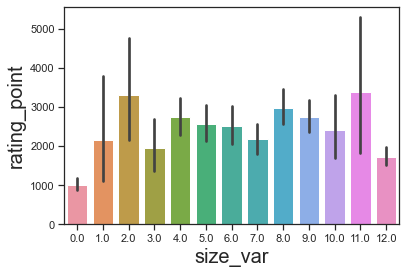

In [30]:
sns.barplot(data = df3, x = 'size_var', y = target)

<AxesSubplot:xlabel='discount_rate', ylabel='rating_point'>

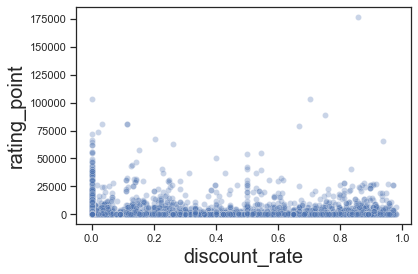

In [123]:
sns.scatterplot(data = df3, x = 'discount_rate', y = target, alpha = 0.3)

<AxesSubplot:xlabel='discount_price', ylabel='rating_point'>

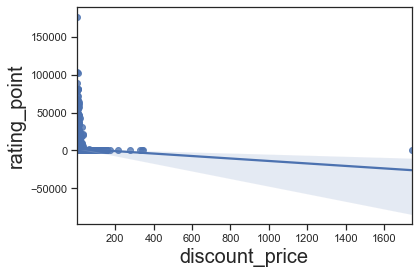

In [124]:
sns.regplot(x = df3['discount_price'], y = df3[target])

In [91]:
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from category_encoders import CatBoostEncoder
from sklearn.impute import SimpleImputer

from catboost import CatBoostRegressor
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score, f1_score


In [41]:
train_val, test = train_test_split(df3, train_size = 0.8, test_size = 0.2, random_state = 2)
train, val = train_test_split(train_val, train_size = 0.8, test_size = 0.2, random_state = 2)

target = 'rating_point'
features = df3.columns.difference([target], sort=False)

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [42]:
encoder = CatBoostEncoder()

X_train_encoded = encoder.fit_transform(X_train, y_train)
X_val_encoded = encoder.transform(X_val, y_val)
X_test_encoded = encoder.transform(X_test, y_test)

In [104]:
from sklearn.metrics import make_scorer

# def MSE(y_true,y_pred):
#     mse = mean_squared_error(y_true, y_pred)
#     print('MSE: %2.3f' % mse)
#     return mse

# def R2(y_true,y_pred):    
#     r2 = r2_score(y_true, y_pred)
#     print('R2: %2.3f' % r2)
#     return r2

# def two_score(y_true,y_pred):    
#     MSE(y_true,y_pred) #set score here and not below if using MSE in GridCV
#     score = R2(y_true,y_pred)
#     return score

# def two_scorer():
#     return make_scorer(two_score, greater_is_better=False) # change for false if using MSE


f1 = make_scorer(f1_score , average='macro')
r2 = make_scorer(r2_score, greater_is_better = True)
mse = make_scorer(mean_squared_error, greater_is_better = False)

In [105]:
cat_basic = CatBoostRegressor(iterations = 500
                             , random_state = 2
#                              , early_stopping_rounds = 30
                             , loss_function = 'RMSE'
                             )


from sklearn.model_selection import GridSearchCV


grids = {
    "max_depth": [1,3, 5,7], 
    "learning_rate" : [0.1, 0.2, 0.3]
    }

fit_params = {"eval_set": [(X_val_encoded, y_val)], 
              "early_stopping_rounds": 30, 
              } 

reg = GridSearchCV(
    cat_basic,
    param_grid=grids,
#     fit_params = params,
    cv=3,
    scoring= r2,
#     error_score="raise",
#     verbose=1,
    n_jobs=-1)
    
reg.fit(X_train_encoded, y_train, **fit_params)
    
print('최적 하이퍼파라미터: ', reg.best_params_)
print('score: ', reg.best_score_)

0:	learn: 6058.5382307	test: 6246.5192044	best: 6246.5192044 (0)	total: 1.75ms	remaining: 875ms
1:	learn: 5927.0544634	test: 6228.8469160	best: 6228.8469160 (1)	total: 3.19ms	remaining: 794ms
2:	learn: 5866.7475690	test: 6250.7849336	best: 6228.8469160 (1)	total: 4.52ms	remaining: 749ms
3:	learn: 5832.6724905	test: 6210.8339362	best: 6210.8339362 (3)	total: 6.09ms	remaining: 755ms
4:	learn: 5753.6028596	test: 6204.0220449	best: 6204.0220449 (4)	total: 7.47ms	remaining: 739ms
5:	learn: 5676.0442694	test: 6188.3642424	best: 6188.3642424 (5)	total: 8.9ms	remaining: 733ms
6:	learn: 5647.2810684	test: 6190.2576880	best: 6188.3642424 (5)	total: 10.3ms	remaining: 723ms
7:	learn: 5613.6569300	test: 6201.1352319	best: 6188.3642424 (5)	total: 11.6ms	remaining: 714ms
8:	learn: 5593.0059058	test: 6228.9387153	best: 6188.3642424 (5)	total: 13ms	remaining: 708ms
9:	learn: 5561.3684635	test: 6265.1714074	best: 6188.3642424 (5)	total: 14.5ms	remaining: 709ms
10:	learn: 5523.4739123	test: 6303.4120975	

In [106]:
pd.DataFrame(reg.cv_results_).sort_values(by='rank_test_score').T

,10,8,0,6,4,3,2,7,1,9,11,5
mean_fit_time,0.330116,0.517616,0.391617,0.337099,0.272272,0.379318,0.293549,0.395276,0.233707,0.251661,0.420874,0.238695
std_fit_time,0.0447413,0.228504,0.0525248,0.00776765,0.0337014,0.0567712,0.0574448,0.0367112,0.0502603,0.0238424,0.0197619,0.0235501
mean_score_time,0.00731468,0.00432221,0.00565203,0.00498573,0.00432142,0.0046552,0.00531967,0.00498676,0.00365671,0.00398914,0.0026594,0.00531848
std_score_time,0.00204777,0.000940493,0.000470585,0.00282103,0.000470472,0.00169438,0.00046946,0.00282165,0.000470246,0.000814491,0.00124396,0.000939931
param_learning_rate,0.3,0.3,0.1,0.2,0.2,0.1,0.1,0.2,0.1,0.3,0.3,0.2
param_max_depth,5,1,1,5,1,7,5,7,3,3,7,3
params,"{'learning_rate': 0.3, 'max_depth': 5}","{'learning_rate': 0.3, 'max_depth': 1}","{'learning_rate': 0.1, 'max_depth': 1}","{'learning_rate': 0.2, 'max_depth': 5}","{'learning_rate': 0.2, 'max_depth': 1}","{'learning_rate': 0.1, 'max_depth': 7}","{'learning_rate': 0.1, 'max_depth': 5}","{'learning_rate': 0.2, 'max_depth': 7}","{'learning_rate': 0.1, 'max_depth': 3}","{'learning_rate': 0.3, 'max_depth': 3}","{'learning_rate': 0.3, 'max_depth': 7}","{'learning_rate': 0.2, 'max_depth': 3}"
split0_test_score,0.00883831,0.0187549,0.0156955,-0.0018217,0.00234101,-0.00252091,0.0144735,-0.00465562,0.00550011,-0.0013131,-8.94466e-05,-0.00109137
split1_test_score,0.0356955,0.0442721,0.0501179,0.0283799,0.0490114,0.026711,0.0165562,0.00600119,0.000732393,0.000286482,0.00762793,0.000922203
split2_test_score,0.0604448,0.0322734,0.0291967,0.0554969,0.0258124,0.0454595,0.034949,0.038696,0.027763,0.0312139,0.0169797,0.0178097


In [109]:
cat_best = reg.best_estimator_

y_train_pred = cat_best.predict(X_train_encoded)
y_val_pred = cat_best.predict(X_val_encoded)

r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)

print("r2_train : ", r2_train)
print("r2_val : ", r2_val)
print("difference : ", r2_train - r2_val)

r2_train :  0.1487743806329037
r2_val :  0.018835125065778335
difference :  0.12993925556712538


In [125]:
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)

print("mae_train : ", mae_train)
print("mae_val : ", mae_val)
print("difference : ", mae_train - mae_val)

mae_train :  2652.2958664498065
mae_val :  2668.2571142498423
difference :  -15.961247800035835


In [ ]:
mse_train = mean_squared_error(y_train, y_train_pred)
mse_val = mean_squared_error(y_val, y_val_pred)

print("mse_train : ", mse_train)
print("mse_val : ", mse_val)
print("difference : ", mse_train - mse_val)

In [126]:
rmse_train = mean_squared_error(y_train, y_train_pred) **0.5
rmse_val = mean_squared_error(y_val, y_val_pred) **0.5

print("rmse_train : ", rmse_train)
print("rmse_val : ", rmse_val)
print("difference : ", rmse_train - rmse_val)

rmse_train :  5676.0442694025805
rmse_val :  6188.364242411658
difference :  -512.3199730090773


In [127]:
baseline = y_train.mean()
y_base_pred = [baseline] * len(y_train)

r2_base = r2_score(y_train, y_base_pred)
mae_base = mean_absolute_error(y_train, y_base_pred)
mse_base = mean_squared_error(y_train, y_base_pred)
rmse_base = mse_base ** 0.5
print("r2_base : ", r2_base)
print("mae_base : ", mae_base)
print("rmse_base : ", rmse_base)

r2_base :  0.0
mae_base :  2818.0380033530528
rmse_base :  6152.100634740719


In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    pipe.named_steps['cat'], # model
    scoring='accuracy', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

X_val_transformed = pipe.named_steps['prep'].transform(X_val)
permuter.fit(X_val_transformed, y_val)

feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

In [56]:
from catboost import Pool

is_cat = (X_train_encoded.dtypes != float)
cat_features_index = np.where(is_cat)[0]

pool = Pool(X_train_encoded, y_train, cat_features=cat_features_index, feature_names=list(X_train_encoded.columns))

reg.plot_tree(tree_idx=0, pool = pool)

AttributeError: 'GridSearchCV' object has no attribute 'plot_tree'

In [ ]:
from sklearn.model_selection import GridSearchCV

grids = {
    "max_depth": [1,4,7], 
    "learning_rate" : [0.1, 0.2, 0.3]
    }

params = {"eval_set": [(X_val3_encoded, y_val3)], 
              "early_stopping_rounds": 10, 
              } 


clf = GridSearchCV(
    cat4,
    param_grid=grids,
#     fit_params = params,
    cv=3,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train3_encoded, y_train3, **fit_params)

print('최적 하이퍼파라미터: ', clf.best_params_)
print('f1_score: ', clf.best_score_)